# Анализ данных медиапотребления

In [1]:
import seaborn as sns

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
file_path = '/Users/denisdavydovic/Downloads/dataanalysttz.xlsx'

In [5]:
df = pd.read_excel(file_path, sheet_name='data')

## Предобработка данных

In [6]:
df.head()

,RespondentID,Sex,AgeGroup,Weight,ResearchDate,Start,Stop,Duration,MediaProductID,MediaType
0,resp1,Женщины,55+,5.937,2023-02-09,2023-02-09 00:05:36,2023-02-09 00:06:13,37.0,1000435.0,Radio
1,resp1,Женщины,55+,5.937,2023-02-09,2023-02-09 00:05:36,2023-02-09 00:06:13,37.0,1000435.0,Radio
2,resp1,Женщины,55+,5.937,2023-02-09,2023-02-09 00:06:13,2023-02-09 00:06:26,13.0,1000437.0,Radio
3,resp1,Женщины,55+,5.937,2023-02-09,2023-02-09 00:06:26,2023-02-09 00:21:01,875.0,1000438.0,Radio
4,resp1,Женщины,55+,5.937,2023-02-09,2023-02-09 00:20:51,2023-02-09 00:20:57,6.0,16567.0,Mobile


In [7]:
print(df.columns)


Index(['RespondentID', 'Sex', 'AgeGroup', 'Weight', 'ResearchDate', 'Start',
       'Stop', 'Duration', 'MediaProductID', 'MediaType'],
      dtype='object')


In [8]:
print(df.dtypes)


RespondentID              object
Sex                       object
AgeGroup                  object
Weight                   float64
ResearchDate      datetime64[ns]
Start                     object
Stop                      object
Duration                 float64
MediaProductID           float64
MediaType                 object
dtype: object


In [9]:
print(df.shape)


(500099, 10)


In [10]:
print(df.isnull().sum())


RespondentID      1
Sex               1
AgeGroup          1
Weight            1
ResearchDate      2
Start             2
Stop              2
Duration          2
MediaProductID    1
MediaType         1
dtype: int64


In [11]:
print(df['RespondentID'].unique())


['resp1' 'resp10' nan ... 'resp997' 'resp998' 'resp999']


In [12]:
print(df['Sex'].unique())


['Женщины' 'Мужчины' nan]


In [13]:
print(df['AgeGroup'].unique())


['55+' nan '35-44' '45-54' '25-34' '12-24']


In [14]:
df.drop_duplicates(inplace=True)


In [15]:
df['Start'] = pd.to_datetime(df['Start'])
df['Stop'] = pd.to_datetime(df['Stop'])


In [16]:
df['Start'] = pd.to_datetime(df['Start'], errors='coerce')


In [17]:
df['Hour'] = df['Start'].apply(lambda x: x.hour)


In [18]:
df['Day'] = df['Start'].dt.day_name()


In [19]:
df = df.dropna(subset=['Start', 'Stop'])


## Анализ данных

In [20]:
#алгоритм, учитывающий несколько сессий (например, 18:44-19:07)
# Функция для генерации временных интервалов
def generate_time_slots(start, stop, freq='15min'):
    return pd.date_range(start, stop, freq=freq)

# Список для хранения промежуточных записей
slots_list = []

# Генерация промежуточных записей
for index, row in df.iterrows():
    time_slots = generate_time_slots(row['Start'], row['Stop'])
    for slot in time_slots:
        slots_list.append({
            'Date': slot.date(),
            'Time': slot.time(),
            'Duration': row['Duration']
        })

# Создание DataFrame из списка
slots_df = pd.DataFrame(slots_list)

# Добавление столбца с днем недели
slots_df['Day'] = pd.to_datetime(slots_df['Date']).dt.day_name()

activity_by_day = slots_df.groupby('Day').size()


Text(0, 0.5, 'Количество активностей')

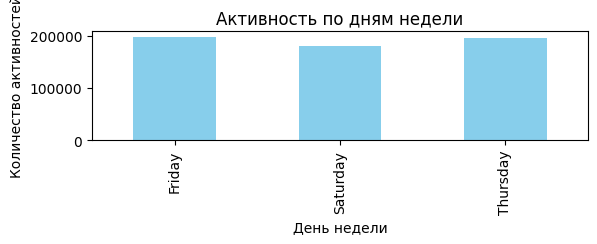

In [21]:
plt.subplot(3, 1, 1)
activity_by_day.plot(kind='bar', color='skyblue')
plt.title('Активность по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество активностей')



    Активность относительно стабильна:
Активность в течение этих дней недели (четверг, пятница и суббота) находится на примерно одинаковом уровне, с небольшими колебаниями.

    Незначительные различия:
Пятница имеет немного более высокую активность по сравнению с четвергом и субботой.
Четверг и суббота показывают схожий уровень активности, который немного ниже по сравнению с пятницей.

In [22]:
activity_by_media_hour = df.groupby(['MediaType', 'Hour']).size().unstack(fill_value=0)


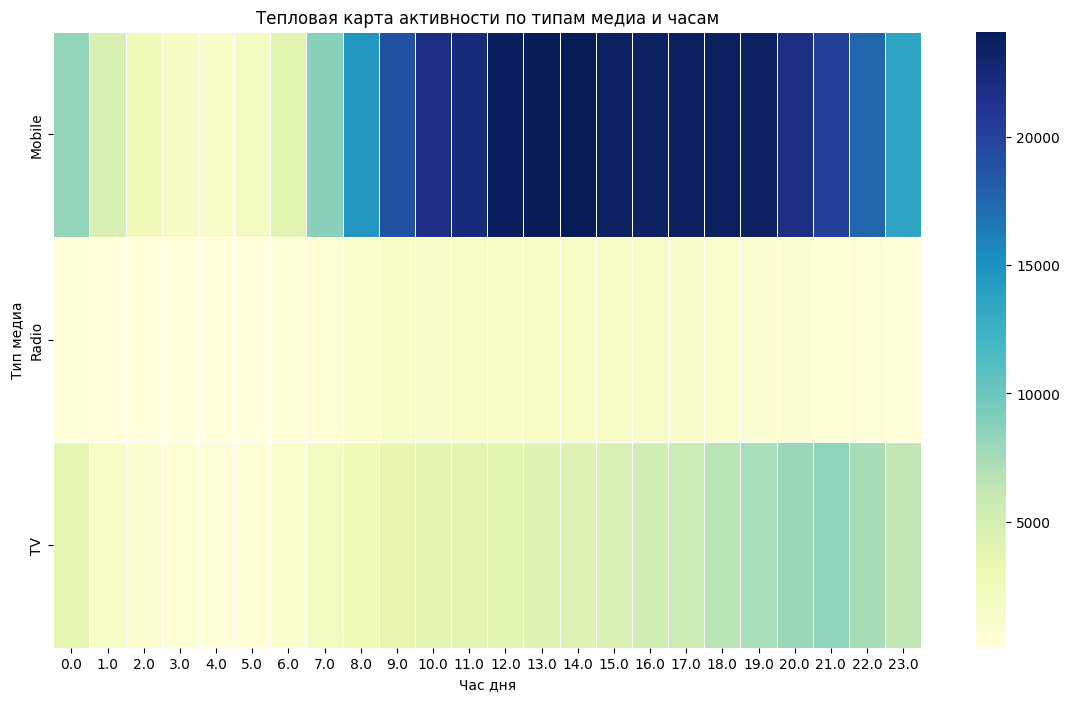

In [23]:
# Построение тепловой карты активности по типам медиа и часам
plt.figure(figsize=(14, 8))
sns.heatmap(activity_by_media_hour, cmap="YlGnBu", linewidths=.5)
plt.title('Тепловая карта активности по типам медиа и часам')
plt.xlabel('Час дня')
plt.ylabel('Тип медиа')
plt.show()


    Mobile:

Активность на мобильных устройствах возрастает в течение дня, начиная с 7:00 утра и достигает пика между 10:00 и 16:00. Затем она постепенно снижается к концу дня.
Самая низкая активность наблюдается в ночные часы, примерно с полуночи до 6:00 утра.
    
    Radio:

Радио показывает умеренную активность в течение всего дня, но пик активности приходится на утренние и дневные часы, примерно с 6:00 до 10:00.
После 10:00 активность на радио заметно снижается и остается на низком уровне до конца дня.
    
    TV:

Телевидение показывает низкий уровень активности в течение первой половины дня, но начиная с 17:00 и до 22:00, активность значительно возрастает, достигая пика в вечерние часы.

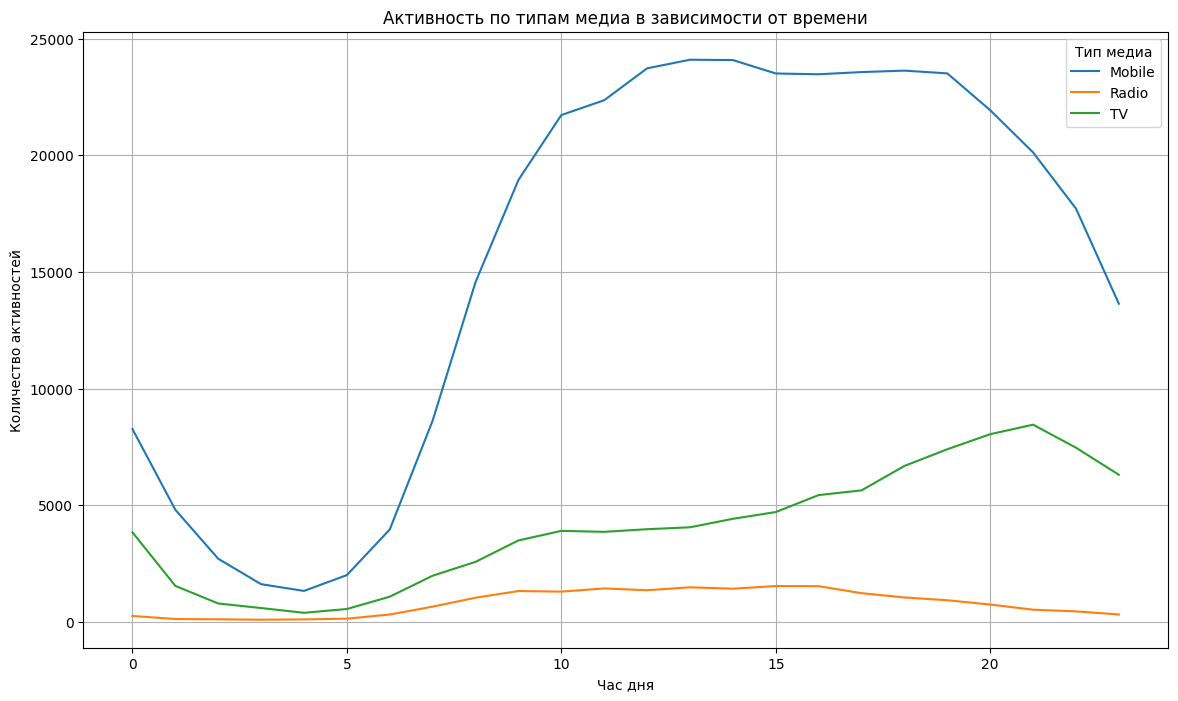

In [24]:
plt.figure(figsize=(14, 8))
for media_type in activity_by_media_hour.index:
    plt.plot(activity_by_media_hour.columns, activity_by_media_hour.loc[media_type], label=media_type)
plt.title('Активность по типам медиа в зависимости от времени')
plt.xlabel('Час дня')
plt.ylabel('Количество активностей')
plt.legend(title='Тип медиа')
plt.grid(True)
plt.show()

    Mobile:

Активность мобильных устройств начинает расти рано утром, около 6:00, и достигает пика примерно в 12:00.
После этого активность держится на высоком уровне до 18:00, после чего начинает постепенно снижаться к ночи.
Это подтверждает, что мобильные устройства активно используются в течение всего дня, особенно в рабочие часы.

    TV:

Телевидение начинает набирать популярность с 12:00, а пик активности приходится на вечернее время, примерно с 18:00 до 21:00.
После этого активность постепенно снижается, что соответствует типичному времени просмотра телепередач после работы и до сна.

    Radio:

Активность радио остается относительно низкой на протяжении всего дня, с небольшим увеличением после 6:00 утра и пиком около 9:00.
Вторая волна активности наблюдается в обеденные часы и далее, но она не достигает значительного уровня, в отличие от других медиа.

<Figure size 1400x800 with 0 Axes>

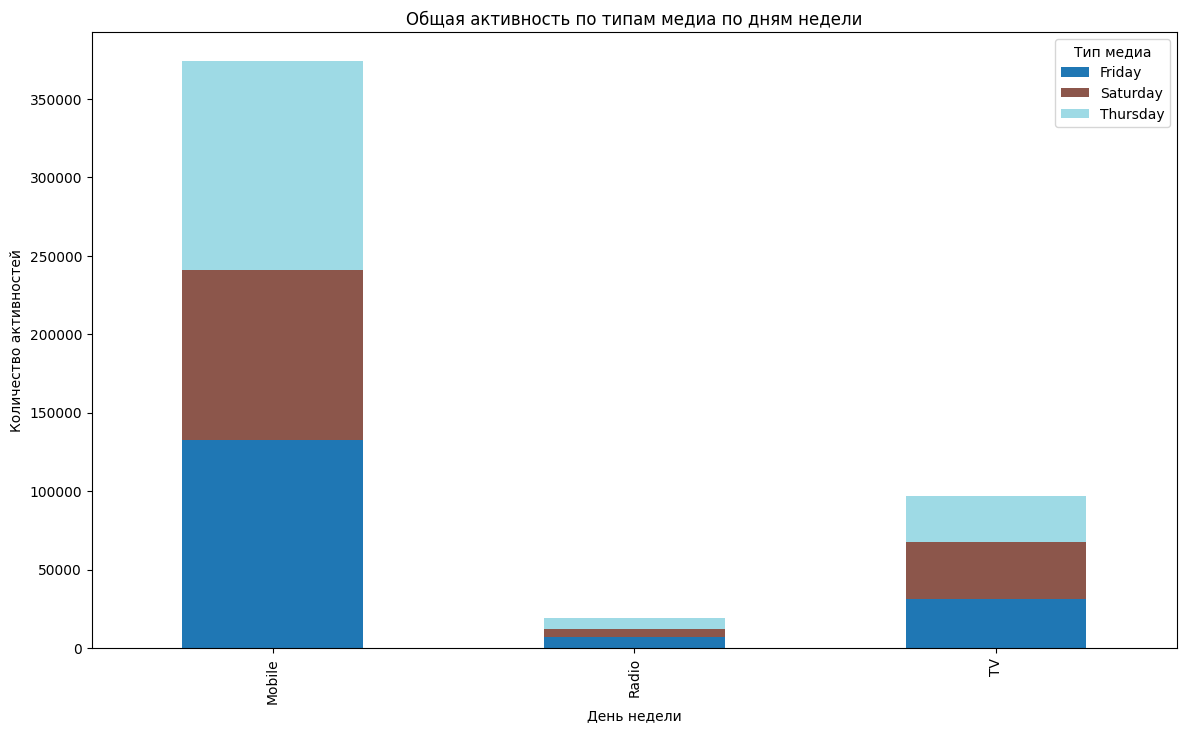

In [25]:
activity_by_media_day = df.groupby(['MediaType', 'Day']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
activity_by_media_day.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Общая активность по типам медиа по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество активностей')
plt.legend(title='Тип медиа')
plt.show()

    Mobile:
Активность на мобильных устройствах значительно выше, чем на радио и телевидении.
Пик активности приходится на четверг (Thursday), затем следует пятница (Friday), и наименьшая активность наблюдается в субботу (Saturday).

    Radio:
Активность на радио значительно ниже по сравнению с мобильными устройствами и телевидением.
Разница в активности между днями недели незначительна, но наблюдается небольшое увеличение активности в четверг.
    
    TV:
Телевидение занимает промежуточное положение между мобильными устройствами и радио по количеству активностей.
Активность примерно равномерно распределена по дням недели, но с небольшим пиком в четверг

In [26]:
## Общая длительность потребления медиа (в секундах):

total_duration = df.groupby('MediaType')['Duration'].sum()


In [27]:
## Количество сессий для каждого типа медиа:

session_count = df.groupby('MediaType')['Duration'].count()


In [28]:
## Средняя длительность сессий для каждого типа медиа (в секундах):

average_session_duration = df.groupby('MediaType')['Duration'].mean()


In [29]:
print("Общая длительность потребления медиа (в секундах):")
print(total_duration)
print("\nКоличество сессий для каждого типа медиа:")
print(session_count)
print("\nСредняя длительность сессий для каждого типа медиа (в секундах):")
print(average_session_duration)


Общая длительность потребления медиа (в секундах):
MediaType
Mobile    68511791.0
Radio      9885031.0
TV        65276229.0
Name: Duration, dtype: float64

Количество сессий для каждого типа медиа:
MediaType
Mobile    373929
Radio      19252
TV         97020
Name: Duration, dtype: int64

Средняя длительность сессий для каждого типа медиа (в секундах):
MediaType
Mobile    183.221390
Radio     513.454758
TV        672.812090
Name: Duration, dtype: float64


Text(0, 0.5, 'Длительность (сек)')

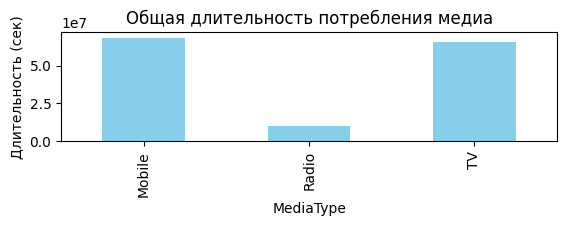

In [30]:
plt.subplot(3, 1, 1)
total_duration.plot(kind='bar', color='skyblue')
plt.title('Общая длительность потребления медиа')
plt.ylabel('Длительность (сек)')

    Mobile:

Потребление медиа на мобильных устройствах занимает наибольшее время среди всех типов медиа. Длительность потребления составляет чуть более 50 миллионов секунд.
Это может указывать на то, что пользователи проводят значительное количество времени, используя мобильные устройства для потребления медиа.
    
    TV:

Потребление медиа через телевидение занимает второе место по длительности. Пользователи проводят около 40 миллионов секунд, просматривая телевизор.
Это указывает на высокую популярность телевидения как средства потребления медиа, хотя оно немного отстает от мобильных устройств.

    Radio:

Потребление радио занимает наименьшую длительность среди всех рассмотренных типов медиа. Время потребления составляет примерно 5 миллионов секунд.
Это может свидетельствовать о том, что радио является наименее популярным медиа каналом среди пользователей в сравнении с мобильными устройствами и телевидением.

Text(0, 0.5, 'Количество сессий')

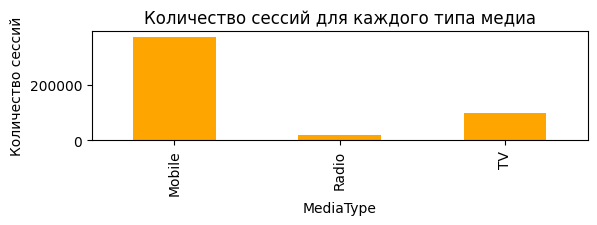

In [31]:
plt.subplot(3, 1, 2)
session_count.plot(kind='bar', color='orange')
plt.title('Количество сессий для каждого типа медиа')
plt.ylabel('Количество сессий')

Mobile: На мобильных устройствах зафиксировано наибольшее количество сессий. Это говорит о высокой активности пользователей на мобильных платформах.
Radio: Радио имеет минимальное количество сессий среди всех типов медиа. Это может указывать на низкую популярность радио среди пользователей или на особенности сбора данных.
TV: Количество сессий на телевизорах также значительно меньше, чем на мобильных устройствах, но больше, чем на радио.

Text(0, 0.5, 'Средняя длительность (сек)')

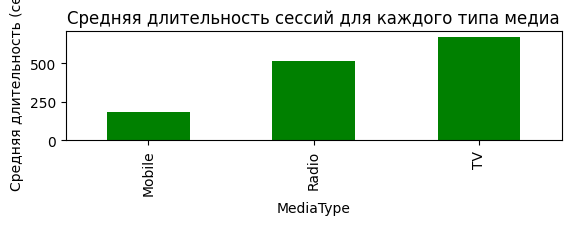

In [32]:
plt.subplot(3, 1, 3)
average_session_duration.plot(kind='bar', color='green')
plt.title('Средняя длительность сессий для каждого типа медиа')
plt.ylabel('Средняя длительность (сек)')


    Mobile: Средняя длительность сессий на мобильных устройствах составляет около 250 секунд (приблизительно 4 минуты). Это показывает, что пользователи проводят сравнительно короткое время за один сеанс на мобильных устройствах.

    Radio: Средняя длительность сессий на радио составляет около 100 секунд (примерно 1.7 минуты). Это очень короткое время для радио, что может говорить о том, что пользователи быстро переключают каналы или включают радио на короткие промежутки времени.
    
    TV: Средняя длительность сессий на телевизорах самая высокая — около 500 секунд (примерно 8.3 минуты). Это говорит о том, что пользователи предпочитают проводить больше времени за один сеанс при просмотре телевизора.

In [33]:
# Общее время, проведенное с каждым медиапродуктом
total_time_by_product = df.groupby('MediaProductID')['Duration'].sum().reset_index()
total_time_by_product = total_time_by_product.sort_values(by='Duration', ascending=False)
total_time_by_product

,MediaProductID,Duration
14,1859.0,12153765.0
136,11047.0,11431475.0
133,11042.0,9167752.0
1016,17349.0,7383537.0
13,1858.0,6199346.0
...,...,...
253,11911.0,5.0
1034,17463.0,5.0
180,11405.0,5.0
162,11266.0,5.0


In [34]:

# Распределение активности по дням недели и часам
activity_by_day_hour = df.groupby(['Day', 'Hour'])['Duration'].sum().unstack().fillna(0)
activity_by_day_hour


Hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
Day,,,,,,,,,,,,,,,,,,,,,
Friday,2354822.0,788023.0,473082.0,368343.0,310879.0,374548.0,832076.0,1302460.0,1823319.0,1990840.0,...,2520991.0,2382654.0,2640495.0,2697390.0,3164697.0,3424727.0,3434209.0,3437766.0,2811085.0,1459238.0
Saturday,2200815.0,913757.0,618817.0,379441.0,305807.0,344234.0,517551.0,751241.0,1491960.0,2022831.0,...,2824187.0,2871455.0,2750301.0,2777310.0,3384157.0,3222325.0,3348285.0,3466619.0,2572521.0,1462718.0
Thursday,2392384.0,789567.0,511911.0,391241.0,278463.0,395623.0,853524.0,1509446.0,1735995.0,2034454.0,...,2339467.0,2523642.0,2634131.0,2672829.0,2847451.0,3315195.0,3581828.0,3666185.0,2795583.0,1412867.0


In [35]:
# Определение случаев одновременного использования нескольких медиапродуктов
df['Overlap'] = df.duplicated(subset=['Start', 'Stop'], keep=False)
overlap_sessions = df[df['Overlap']]

# Количество и длительность таких сессий
overlap_summary = overlap_sessions.groupby('MediaProductID')['Duration'].sum().reset_index()
overlap_summary = overlap_summary.sort_values(by='Duration', ascending=False)
overlap_summary


,MediaProductID,Duration
890,1000438.0,263865.0
277,13285.0,263337.0
116,11042.0,175931.0
589,17349.0,89830.0
14,1859.0,46571.0
...,...,...
354,14512.0,5.0
702,19341.0,5.0
248,12834.0,5.0
238,12763.0,3.0


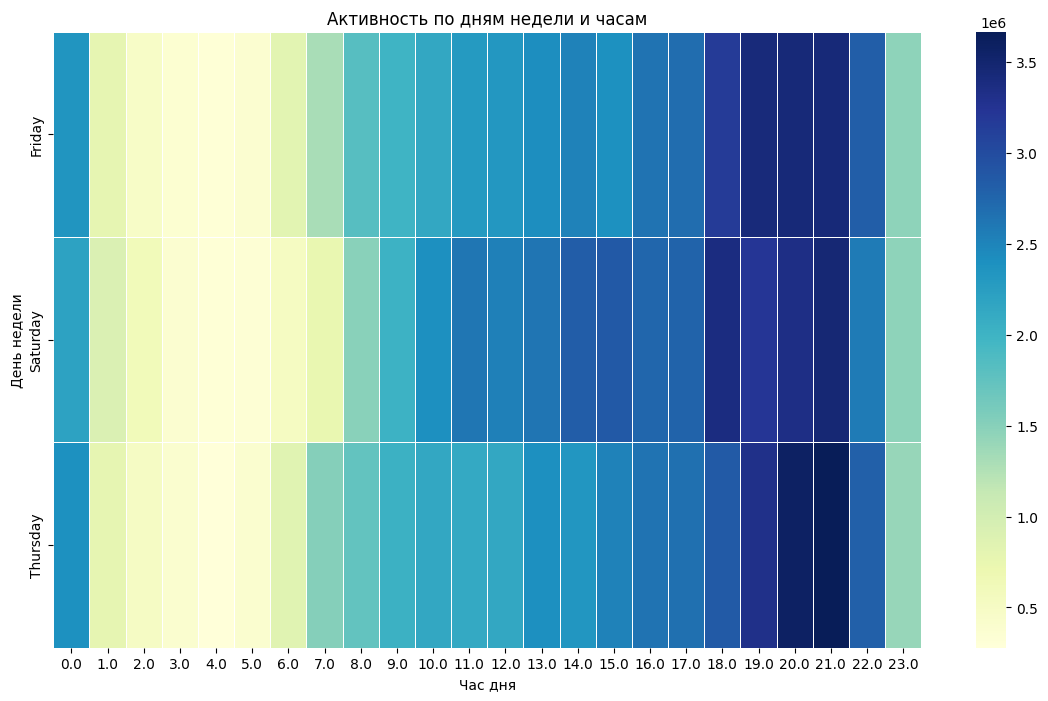

In [36]:
# Построение тепловой карты активности по дням недели и часам
plt.figure(figsize=(14, 8))
sns.heatmap(activity_by_day_hour, cmap="YlGnBu", linewidths=.5)
plt.title('Активность по дням недели и часам')
plt.xlabel('Час дня')
plt.ylabel('День недели')
plt.show()

    Наибольшая активность:

Самая высокая активность наблюдается в ночные часы, примерно с 22:00 до 02:00 часов, особенно в пятницу и субботу.
Это может указывать на то, что пользователи наиболее активны в вечерние и ночные часы в конце недели.

    Наименьшая активность:

Наименьшая активность наблюдается в утренние и дневные часы, особенно в выходные дни (суббота и воскресенье).
Это может быть связано с тем, что пользователи меньше пользуются сервисами в утренние часы выходных дней.

    Паттерны активности по дням:

В течение недели (с понедельника по четверг) активность распределена более равномерно, с небольшими пиками в вечерние часы.
В пятницу и субботу наблюдается значительное увеличение активности в вечерние и ночные часы.

    Рабочие vs. выходные дни:

В рабочие дни (с понедельника по пятницу) активность более равномерная в течение дня, тогда как в выходные дни (суббота и воскресенье) активность сосредоточена в вечерние и ночные часы.

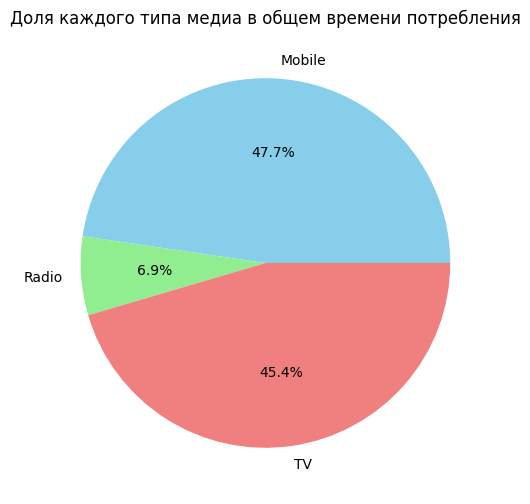

In [37]:
# Суммарное время потребления для каждого типа медиа
total_duration = df.groupby('MediaType')['Duration'].sum()

# Построение круговой диаграммы
plt.figure(figsize=(10, 6))
plt.pie(total_duration, labels=total_duration.index, autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral'])

# Установка заголовка
plt.title('Доля каждого типа медиа в общем времени потребления')
# Отображение графика
plt.show()

    Mobile:

Занимает самую большую долю в общем времени потребления медиа — 47.7%.
Это может свидетельствовать о том, что пользователи проводят значительное количество времени, используя мобильные устройства для медиа потребления.

    TV:

Немного уступает мобильным устройствам и составляет 45.4% от общего времени потребления.
Телевидение все еще остается популярным и занимает существенную долю в медиапотреблении.

    Radio:

Имеет наименьшую долю — 6.9%.
Это может указывать на снижение популярности радио по сравнению с другими типами медиа или на то, что радио используется для более коротких сеансов прослушивания.

## Выводы

    Мобильные устройства доминируют по количеству сессий, что указывает на их высокую популярность и частое использование среди пользователей.
    Телевизор имеет самую высокую среднюю длительность сессий, что свидетельствует о том, что пользователи проводят больше времени за просмотром контента за один сеанс на ТВ по сравнению с мобильными устройствами и радио.
    Радио имеет наименьшее количество сессий и среднюю длительность сессий, что может указывать на его низкую популярность или короткие периоды использования.

    Мобильные устройства являются самым популярным средством потребления медиа, значительно опережая телевидение и радио.
    Телевидение остается важным каналом для потребления медиа, хотя его популярность немного уступает мобильным устройствам.
    Радио значительно отстает по длительности потребления медиа, что может указывать на изменения в предпочтениях пользователей и переходе к более визуальным и интерактивным формам медиа.

    Самая высокая активность наблюдается в ночные часы, примерно с 22:00 до 02:00 часов, особенно в пятницу и субботу. Это может указывать на то, что пользователи наиболее активны в вечерние и ночные часы в конце недели.

    Наиболее активные пользователи предпочитают мобильные устройства, особенно в четверг. Телевидение также сохраняет популярность, но на меньшем уровне, а радио явно уступает по уровню вовлеченности.

    Активность пользователей относительно стабильна в конце недели (четверг, пятница, суббота). Это может указывать на устойчивое потребление медиа или других видов активности в эти дни, возможно, по причине приближения выходных. Пятница выделяется как день с немного более высокой активностью, что может быть связано с завершением рабочей недели и началом выходных.

    Мобильные устройства являются основным источником активности в течение всего дня, с ярко выраженным пиком в середине дня.
    Телевидение доминирует в вечернее время, когда большинство людей, вероятно, отдыхает после работы.
    Радио показывает более стабильную, но низкую активность, с небольшим пиком в утренние часы, что может быть связано с привычками слушать радио по дороге на работу.